In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import pickle
import seaborn as sns

from sklearn.model_selection import train_test_split

In [3]:
# TF and Keras imports
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers import Dense, Dropout, Input #, GlobalAveragePooling2D, , Concatenate, Add
from tensorflow.keras.metrics import SparseCategoricalAccuracy, SparseTopKCategoricalAccuracy
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

from keras.preprocessing import dataset_utils
from keras.preprocessing import image_dataset

!pip install tensorflow-addons
import tensorflow_addons as tfa

     |████████████████████████████████| 1.1 MB 6.5 MB/s 


In [4]:
# Enable/Disable Eager Execution
# Reference: https://www.tensorflow.org/guide/eager
# TensorFlow's eager execution is an imperative programming environment that evaluates operations immediately, 
# without building graphs

#tf.compat.v1.disable_eager_execution()
#tf.compat.v1.enable_eager_execution()

print("tensorflow version", tf.__version__)
print("keras version", tf.keras.__version__)
print("Eager Execution Enabled:", tf.executing_eagerly())

# Get the number of replicas 
strategy = tf.distribute.MirroredStrategy()
print("Number of replicas:", strategy.num_replicas_in_sync)

devices = tf.config.experimental.get_visible_devices()
print("Devices:", devices)
print(tf.config.experimental.list_logical_devices('GPU'))

print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("All Physical Devices", tf.config.list_physical_devices())

# Better performance with the tf.data API
# Reference: https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f"Autotune Value = {AUTOTUNE}")

tensorflow version 2.8.0
keras version 2.8.0
Eager Execution Enabled: True
INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)
Number of replicas: 1
Devices: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
[]
GPU Available:  []
All Physical Devices [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]
Autotune Value = -1


In [5]:
hnm_file_format = '/content/drive/MyDrive/Temporary/CS25_Project/HnM_{}.parquet'
hnm_img_format = '/content/drive/MyDrive/Temporary/CS25_Project/images/HnM/{}'

In [6]:
# folder names
hnm_img_final = '/content/drive/MyDrive/Temporary/CS25_Project/images_final/HnM/'
hnm_img_final_top = '/content/drive/MyDrive/Temporary/CS25_Project/images_final'

hnm_img_resized = '/content/drive/MyDrive/Temporary/CS25_Project/images_resized/HnM/'
hnm_img_resized_top = '/content/drive/MyDrive/Temporary/CS25_Project/images_resized'

In [7]:
model_wts_path = '/content/drive/MyDrive/Temporary/CS25_Project/'
model_hist_path = '/content/drive/MyDrive/Temporary/CS25_Project/'

In [8]:
## load the data frame
df = pd.read_parquet(hnm_file_format.format('Final_Input_Df'))
df['Category_Name'] = df['Category_Name'].astype('category')
df['Category_Name_Code'] = df['Category_Name'].cat.codes


df_filters = pd.read_parquet(hnm_file_format.format('Final_Input_Filters'))
with open('/content/drive/MyDrive/Temporary/CS25_Project/HnM_FilterValueLists.pkl', 'rb') as file_pi:
    filter_value_lists = pickle.load(file_pi)

In [9]:
df.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Name_Code
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26
4,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26
5,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26
6,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,26


In [10]:
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ..."
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [11]:
# generating a list of filter options
filter_options = [f[0].split('_')[0] for f in filter_value_lists]

### Cursory Checks on the Data

In [12]:
df_filters.isna().sum()

Code                      0
Name                      0
Img_Ext                   0
Parent_Category           0
Top_Category              0
Parent_Category_Name      0
Category_Name             0
Category_Filters          0
Product_Filters         154
Filter_Values             0
dtype: int64

In [13]:
# Dropping cols with null values
df_filters = df_filters.dropna().reset_index(drop=True)

In [14]:
df_filters['Product_Filters'].apply(lambda x: len(x)).describe()

count    14302.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: Product_Filters, dtype: float64

In [15]:
(df_filters['Product_Filters'].apply(lambda x: len(x)) == len(filter_options)).value_counts()

True    14302
Name: Product_Filters, dtype: int64

Column Product Filters contains a binary list of applicable filters to that product. This can be used to switch on / off certain neurons depending on the categories

In [16]:
# Checking that the length of the lists in filter values is also equal to 20
df_filters['Filter_Values'].apply(lambda x: len(x)).describe()

count    14302.0
mean        20.0
std          0.0
min         20.0
25%         20.0
50%         20.0
75%         20.0
max         20.0
Name: Filter_Values, dtype: float64

In [17]:
# checking that we have filter values for all filter options i.e. the nr of lists within filter values with length > 0 should be the same as the sum of the Product Filters list
df_filters.apply(lambda row: (np.sum([(len(y) > 0)*1 for y in row['Filter_Values']]) == np.sum(row['Product_Filters'])), axis=1).value_counts()

True     14249
False       53
dtype: int64

In [18]:
# found some unequal elements - exploring these further
uneq_ids = df_filters.apply(lambda row: (np.sum([(len(y) > 0)*1 for y in row['Filter_Values']]) == np.sum(row['Product_Filters'])), axis=1)

In [19]:
print(df_filters[~uneq_ids].iloc[0]['Product_Filters'])
print(df_filters[~uneq_ids].iloc[0]['Filter_Values'])

[1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0])
 array([], dtype=int64)
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0])
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([], dtype=int64) array([], dtype=int64) array([], dtype=int64)
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

In [20]:
# 53 values : dropping these for now to avoid confusion
df_filters = df_filters.drop(index=df_filters[~uneq_ids].index).reset_index(drop=True)

In [21]:
df_filters.shape

(14249, 10)

In [22]:
# adding a column with image paths in it
df_filters['image_paths'] = df_filters.apply(lambda row: f"{hnm_img_resized}{row['Code']}{row['Img_Ext']}", axis=1)
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values,image_paths
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ...",/content/drive/MyDrive/Temporary/CS25_Project/...
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",/content/drive/MyDrive/Temporary/CS25_Project/...


### Configuring some needed variables

In [23]:
# load a display some sample images and then get it's shape since it'll needed in the model input

In [24]:
img_shape = (224, 224, 3)

In [25]:
# set up the output size for each of the different output layers - each would vary
all_lens = np.concatenate(df_filters['Filter_Values'].apply(lambda x: np.array([len(y) for y in x])).values).reshape(-1, 20)

In [26]:
out_size = []
for i in range(all_lens.shape[1]):
    lens = all_lens[:, i]
    out_size.append(int(np.mean(lens[lens > 0])))

# out_size = [out_size[0]]
out_size

[43, 13, 18, 12, 4, 9, 8, 3, 10, 9, 9, 3, 19, 152, 21, 4, 5, 9, 111, 4]

Creating a column for each Filter Option

In [27]:
col_names = [f'Filter_Values_{x}' for x in range(len(out_size))]
df_filters = df_filters.merge(pd.DataFrame(df_filters['Filter_Values'].tolist(), columns=col_names), left_index=True, right_index=True, how='left')

In [28]:
# ensuring that all arrays in each column are of the same length
for i, size in enumerate(out_size):
    df_filters[col_names[i]] = df_filters[col_names[i]].apply(lambda x: x if len(x) == size else np.zeros(size))

In [29]:
df_filters.isna().sum()

Code                    0
Name                    0
Img_Ext                 0
Parent_Category         0
Top_Category            0
Parent_Category_Name    0
Category_Name           0
Category_Filters        0
Product_Filters         0
Filter_Values           0
image_paths             0
Filter_Values_0         0
Filter_Values_1         0
Filter_Values_2         0
Filter_Values_3         0
Filter_Values_4         0
Filter_Values_5         0
Filter_Values_6         0
Filter_Values_7         0
Filter_Values_8         0
Filter_Values_9         0
Filter_Values_10        0
Filter_Values_11        0
Filter_Values_12        0
Filter_Values_13        0
Filter_Values_14        0
Filter_Values_15        0
Filter_Values_16        0
Filter_Values_17        0
Filter_Values_18        0
Filter_Values_19        0
dtype: int64

### Custom Loss Function: not using for now

In [30]:
# def get_loss(y_true, y_pred):
#     """
#     Return weighted loss value.
#     Args:
#         y_true (Tensor): Tensor of true labels, size is (num_examples, num_classes)
#         y_pred (Tensor): Tensor of predicted labels, size is (num_examples, num_classes)
#     Returns:
#         loss (Float): overall scalar loss summed across all classes
#     """
#     # return tf.keras.losses.binary_crossentropy(y_true, y_pred)
#     # initialize loss to zero
#     loss = 0.0
#     # cast true values to float else Keras throws an error
#     # y_true = tf.cast(y_true, dtype=tf.float32)    

#     # continue if y_true is all 0
#     # if tf.math.equal(tf.cast(tf.math.reduce_sum(y_true), dtype=tf.int64), tf.constant(0, dtype=tf.int64)):
#     #     return loss

#     # loss += tf.keras.losses.binary_crossentropy(y_true[i][j], y_pred[j][i])
#     loss = tf.keras.losses.binary_crossentropy(y_true, y_pred)

#     return loss

#     # for i in range(len(pos_weights)):
#     #     # for each class, add average weighted loss for that class
#     #     loss += K.mean(-(pos_weights[i] * y_true[:,i] * K.log(y_pred[:,i] + epsilon)
#     #                         + neg_weights[i] * (1 - y_true[:,i]) * K.log(1 - y_pred[:,i] + epsilon)))
#     # return loss


### Create Custom Dataset for NN

In [31]:
def generate_datasets(img_paths, labels = None, product_filters = None, filter_values = None, seed=25, batch_size=32, 
                    image_size=img_shape[:2], num_channels=3, interpolation='bilinear', crop_to_aspect_ratio=False,
                    shuffle=True):
    """
        Sub-function to return a data set given a list of image paths and associated labels + addl information
        
        :param image_paths: paths to images
        :param labels: list of associated labels for each img
        :param cat_inputs: np array with cat_inputs for each img
        
        length of all inputs should be same as nr of images in directory
        
    """

    # generate dataset
    path_ds = tf.data.Dataset.from_tensor_slices(img_paths)
    args = (image_size, num_channels, interpolation, crop_to_aspect_ratio)
    img_ds = path_ds.map(
      lambda x: image_dataset.load_image(x, *args), num_parallel_calls=tf.data.AUTOTUNE
    )

    # prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(product_filters))
    if labels is None:
        prod_ds = tf.data.Dataset.from_tensor_slices(tf.convert_to_tensor(np.concatenate(product_filters).reshape(-1, 20)))

        filt_ds = []
        for i, size in enumerate(out_size):
            vals = np.concatenate(filter_values[:, i]).reshape(-1, size)
            filt_ds.append(
                tf.data.Dataset.from_tensor_slices(vals)
            )

        # filt_ds = tuple(tf.data.Dataset.from_tensor_slices(tf.ragged.constant(f)) for f in filter_values)
        filt_ds = tf.data.Dataset.zip(tuple(f for f in filt_ds))

        inputs_ds = tf.data.Dataset.zip((img_ds, prod_ds))
        img_ds = tf.data.Dataset.zip((inputs_ds, filt_ds))
    else:
        labels_ds = tf.Data.Dataset.from_tensor_slides(tf.convert_to_tensor(labels))

        img_ds = tf.data.Dataset.zip((img_ds, labels_ds))

    
    if shuffle:
        img_ds = img_ds.shuffle(buffer_size=batch_size * 8, seed=seed)
    img_ds = img_ds.batch(batch_size)
    return img_ds
    

In [32]:
# train, val split
df_train, df_val = train_test_split(df_filters, train_size=0.8, random_state=25)

In [33]:
batch_size = 256

images_train = generate_datasets(df_train['image_paths'].values, df_train['Product_Filters'].values, df_train[col_names].values, batch_size=batch_size)
images_val = generate_datasets(df_val['image_paths'].values, df_val['Product_Filters'].values, df_val[col_names].values, batch_size=batch_size)

### Custom Layer for switching neurons on/off

In [34]:
class SwitchSigmoidLayer(tf.keras.layers.Dense):
    
    def __init__(self, units, *args, **kwargs):
        self.units = units
        super().__init__(units, *args, **kwargs)
    
    # def build(self, input_shape):
    #     self.kernel = self.add_weight("kernel", shape=(int(input_shape[-1]),))
    
    def call(self, inputs, inputs_mask):
        # check inputs_mask - if this layer id is 0 in that, set kernel to 0
        # return super().call(inputs)
        return tf.multiply(tf.tile(inputs_mask, [1, self.units]), super().call(inputs))
        # return tf.cond(tf.equal(inputs_mask, 0), lambda: tf.zeros(self.units), lambda: super().call(inputs))
        # return tf.multiply(inputs, self.kernel)

### Custom callback function to print loss and accuracy

In [35]:
class CombinedMetric(tf.keras.callbacks.Callback):
    def __init__(self, out_size):
        self.out_size = out_size
        self.epoch = 0
        super(CombinedMetric, self).__init__()

    def on_epoch_begin(self, epoch, logs={}):
        return

    def on_epoch_end(self, epoch, logs={}):
        self.epoch += 1
        logs['accuracy'] =  sum([logs[f'Switch_{i}_accuracy'] for i in range(self.out_size)]) / self.out_size
        logs['val_accuracy'] =  sum([logs[f'val_Switch_{i}_accuracy'] for i in range(self.out_size)]) / self.out_size
        print(f"Epoch: {self.epoch}: Loss = {logs['loss']:.2f}; Accuracy = {logs['accuracy']:.2%}; Val Accuracy = {logs['val_accuracy']:.2%};")
        # else:
        #     print(f"Epoch: {self.epoch}: Loss = {logs['loss']:.2f}; Accuracy = {logs['accuracy']:.2%}")


### Model Architecture

In [47]:
models = {
    'Filters_Resnet50_Exp_2D_500E': {
        'model': 'ResNet50',
        'preprocess': 'resnet50',
        'base_model_pooling': 'max',
        'epochs': 500,
        'dense_layers': 2,
        'input_filters': True
    },
}

In [50]:
def ds_preprocess(ds, model_params):

    if model_params.get('equalize', False):
        if model_params.get('concat', False):
            if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
                ds = ds.map(lambda x, y: ((x[0], tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
            else:
                ds = ds.map(lambda x, y: ((x, tfa.image.equalize(x)), y), num_parallel_calls=AUTOTUNE)
        else:
            if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
                ds = ds.map(lambda x, y: ((tfa.image.equalize(x[0]), x[1]), y), num_parallel_calls=AUTOTUNE)
            else:
                ds = ds.map(lambda x, y: (tfa.image.equalize(x), y), num_parallel_calls=AUTOTUNE)

    # preprocess train and test sets if required
    if model_params.get('preprocess', False):
        if model_params.get('concat', False):
            if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
                ds = ds.map(
                    lambda x, y: (
                        (
                            eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
                            eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
                            x[2]
                        ),
                        y
                        ),
                        num_parallel_calls=AUTOTUNE
                        )
            else:
                ds = ds.map(
                    lambda x, y: (
                        (
                            eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]),
                            eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[1]),
                        ),
                        y
                        ),
                        num_parallel_calls=AUTOTUNE
                        )
        else:
            if model_params.get('input_filters', True): # handle extra complexity that x has input_masks also
                ds = ds.map(lambda x, y: ( (eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x[0]), x[1]), y ), num_parallel_calls=AUTOTUNE)
            else:
                ds = ds.map(lambda x, y: ( eval('tf.keras.applications.' + model_params['preprocess'] + '.preprocess_input')(x), y ), num_parallel_calls=AUTOTUNE)

    return ds


In [37]:
def create_model(model_name, model_params, load_wts = False):
    """
        :param model_params: dict with following details -
            model: the name of the keras app to use as the base model
            base_model_pooling: the type of pooling to use in the keras app (avg or max)
            preprocess: the name of the module which has the preprocess function
            dense_layers: the nr of dense layers to include
            epochs: the nr of epochs to train for

    """

    base_model = eval('tf.keras.applications.' + model_params['model'])(include_top=False, input_shape=img_shape, pooling=model_params['base_model_pooling'])

    x = base_model.output

    # let's add a fully-connected layers
    for _ in range(model_params['dense_layers']):
        x = Dense(256, activation='relu')(x)
        x = Dropout(0.5)(x)

    # set up custom layers which will be enabled or disabled depending on the product
    # 20 neurons required in this layer
    input_mask = Input(shape=(20,))
    # x = SwitchLayer(20, trainable=False)(x, input_mask)

    # pass to final prediction layers - we need 20 different layers for outputs, each having sigmoid outputs
    output_layers = []
    # for i in range(20):
    #     output_layers.append(Dense(out_size[i], activation='sigmoid', name=f'OutputLayer_{i}')(x[i]))

    masks = tf.split(input_mask, len(out_size), axis=1)

    for i, size in enumerate(out_size):
        output_layers.append(SwitchSigmoidLayer(size, activation='sigmoid', use_bias=False, name=f'Switch_{i}')(x, masks[i])) #input_mask))

    # and a logistic layer -- with classes = nr_labels
    # predictions = Dense(nr_labels, activation='softmax')(x)

    # this is the model we will train
    model = Model(inputs=[base_model.input, input_mask], outputs=output_layers)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    # compile the model (should be done *after* setting layers to non-trainable)
    model.compile(
        optimizer=Adam(learning_rate=1e-4), 
        loss=[tf.keras.losses.binary_crossentropy]*len(out_size), #['binary_crossentropy'], #'binary_crossentropy', #get_loss, 
        metrics = 'accuracy',
        # metrics=[SparseCategoricalAccuracy(name='cat_acc'), SparseTopKCategoricalAccuracy(k=3, name='top3_cat_acc')]
    )

    if load_wts:
        model.load_weights(f"{model_wts_path}{model_name}.h5")

    return model





In [44]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
model_hists = {}


for model_name, model_params in models.items():
    K.clear_session()
    if os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
            model_hists[model_name] = pickle.load(file_pi)
        # we've completed this one... let's keep going
        print(f"Skipping {model_name} since this is already completed.")
        continue

    print(f"Starting training with {model_name}")
    model = create_model(model_name, model_params)
    # model.compile(optimizer=Adam(learning_rate=1e-3), loss=SparseCategoricalCrossentropy(), metrics=[Accuracy])

    images_train_f = ds_preprocess(images_train, model_params)
    images_val_f = ds_preprocess(images_val, model_params)

    images_train_f = images_train_f.prefetch(1)
    images_val_f = images_val_f.prefetch(1)

    print(f"All ready! Starting fit!")
    # model.summary()
    hist = model.fit(
        images_train_f,
        epochs=model_params['epochs'], 
        batch_size=batch_size, 
        validation_data=images_val_f,
        verbose=True, 
        callbacks = [CombinedMetric(len(out_size)), es]
    )
  
    model.save_weights(f"{model_wts_path}{model_name}.h5")
  
    min_loss_idx = np.argmin(hist.history['val_loss'])

    model_hists[model_name] = hist
    with open(f"{model_hist_path}{model_name}.pkl", 'wb') as file_pi:
        pickle.dump(hist.history, file_pi)

    print(f"Completed training of {model_name} with max validation accuracy: {hist.history['val_accuracy'][min_loss_idx]:.2%} at Epoch Nr {min_loss_idx+1}")


    model = create_model(model_params)
    # print(model.summary())


Skipping Filters_Resnet50_Exp_2D_500E since this is already completed.


### Checking Model Results

In [39]:
# get all model histories and their accuracy

model_hists = {}

for model_name, model_params in models.items():
    if not os.path.exists(f"{model_hist_path}{model_name}.pkl"):
        print(f"File not found - {model_name}")
    with open(f"{model_hist_path}{model_name}.pkl", 'rb') as file_pi:
        model_hists[model_name] = pickle.load(file_pi)

    hist = model_hists[model_name]
    
    min_loss_idx = np.argmin(hist['val_loss'])
    print(f"{model_name}... \n\tMax validation accuracy: {hist['val_accuracy'][min_loss_idx]:.2%};\n\tMin Loss: {hist['val_loss'][min_loss_idx]:.6f};\n\tAt Epoch Nr {min_loss_idx+1}")
    print(f"\t\tVal Accuracy by Output Layer:")
    for i in range(len(out_size)):
        print(f"\t\t\tSwitch_{i} ({out_size[i]} options) = {hist[f'val_Switch_{i}_accuracy'][min_loss_idx]:.2%}")


Filters_Resnet50_Exp_2D_500E... 
	Max validation accuracy: 90.73%;
	Min Loss: 0.340750;
	At Epoch Nr 187
		Val Accuracy by Output Layer:
			Switch_0 (43 options) = 98.00%
			Switch_1 (13 options) = 97.19%
			Switch_2 (18 options) = 51.82%
			Switch_3 (12 options) = 85.82%
			Switch_4 (4 options) = 99.82%
			Switch_5 (9 options) = 92.28%
			Switch_6 (8 options) = 99.58%
			Switch_7 (3 options) = 99.30%
			Switch_8 (10 options) = 84.88%
			Switch_9 (9 options) = 95.72%
			Switch_10 (9 options) = 96.49%
			Switch_11 (3 options) = 99.40%
			Switch_12 (19 options) = 87.19%
			Switch_13 (152 options) = 61.54%
			Switch_14 (21 options) = 98.56%
			Switch_15 (4 options) = 98.95%
			Switch_16 (5 options) = 98.11%
			Switch_17 (9 options) = 99.02%
			Switch_18 (111 options) = 77.12%
			Switch_19 (4 options) = 93.82%


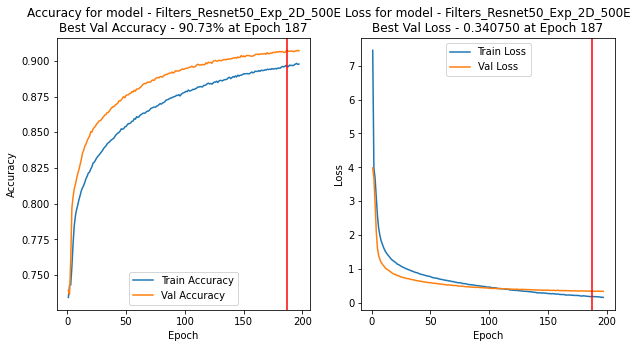

In [40]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5), sharex=True)

if len(axes.shape) < 2: # reshape it
    axes = axes.reshape(-1, 2)

for idx, model in enumerate(models.keys()):
    with open(f"{model_hist_path}{model}.pkl", 'rb') as file_pi:
        hist = pickle.load(file_pi)

    best_epoch = np.argmin(hist['val_loss'])

    sns.lineplot(x=range(1, len(hist['accuracy']) + 1 ), y=hist['accuracy'], ax=axes[idx][0], label='Train Accuracy')
    sns.lineplot(x=range(1, len(hist['val_accuracy']) + 1 ), y=hist['val_accuracy'], ax=axes[idx][0], label='Val Accuracy')

    axes[idx][0].set(
        title=f"Accuracy for model - {model}\nBest Val Accuracy - {hist['val_accuracy'][best_epoch]:.2%} at Epoch {best_epoch+1}",
        xlabel="Epoch",
        ylabel="Accuracy"
    )

    sns.lineplot(x=range(1, len(hist['loss']) + 1 ), y=hist['loss'], ax=axes[idx][1], label='Train Loss')
    sns.lineplot(x=range(1, len(hist['val_loss']) + 1 ), y=hist['val_loss'], ax=axes[idx][1], label='Val Loss')

    axes[idx][1].set(
        title=f"Loss for model - {model}\nBest Val Loss - {hist['val_loss'][best_epoch]:.6f} at Epoch {best_epoch+1}",
        xlabel="Epoch",
        ylabel="Loss"
    )

    axes[idx][0].axvline(x=best_epoch+1, color='red')
    axes[idx][1].axvline(x=best_epoch+1, color='red')

plt.show()

### Plotting and interpreting model results

In [41]:
df_filters.head()

,Code,Name,Img_Ext,Parent_Category,Top_Category,Parent_Category_Name,Category_Name,Category_Filters,Product_Filters,Filter_Values,...,Filter_Values_10,Filter_Values_11,Filter_Values_12,Filter_Values_13,Filter_Values_14,Filter_Values_15,Filter_Values_16,Filter_Values_17,Filter_Values_18,Filter_Values_19
0,1071498001,Cut-out-Shirt,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0]"
1,1069183001,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0]"
2,1069183002,Kurzes Shirt mit Cut-out,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0]"
3,1021919001,Pullover mit Cut-outs,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[[], [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], ...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 1, 0]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0]"
4,1062813001,Tanktop,.jpg,0.0,Women,Shirts & Tops,Women_Shirts-&-Tops,"[0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, ...","[0.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, ...","[[], [], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",...,"[0, 0, 1, 0, 0, 0, 0, 0, 0]","[0.0, 0.0, 0.0]","[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 1]","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[0.0, 0.0, 0.0, 0.0]"


In [42]:
sel_model_name = 'Filters_Resnet50_Exp_2D_500E'
sel_model = models[sel_model_name]

model = create_model(sel_model_name, sel_model, load_wts=True)


94781440/94765736 [==============================] - 0s 0us/step


In [ ]:
images_val_t = ds_preprocess(images_val, sel_model)

for imgs, labels in images_val_t.take(1):
    break